<a href="https://colab.research.google.com/github/KatherineKischenko/DL-7/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2



1. Выберите временной ряд с ценами актива (предпочтительно с явной сезонностью, например, акции компании с сезонным бизнесом).
Проведите декомпозицию временного ряда на тренд, сезонность и остаток.
2. Визуализируйте компоненты декомпозиции.
3. Проанализируйте сезонность: определите периодичность и амплитуду сезонных колебаний.
4. Удалите сезонность из ряда и сравните исходный ряд с десезонализированным.
5. Постройте прогноз на основе выявленных тренда и сезонности на 12 периодов вперед. Оцените качество прогноза, используя метрики MAE и RMSE. Сделайте выводы о влиянии сезонности на цены актива и эффективности прогнозирования.
6. Проведите тест на стационарность ряда (тест Дики-Фуллера). Если ряд нестационарен, приведите его к стационарному виду.
7. Постройте и сравните модели AR, MA, ARMA и ARIMA. Подберите оптимальные параметры для каждой модели, используя информационные критерии (AIC, BIC). Проведите диагностику остатков моделей. Сделайте прогноз на 30 дней вперед для каждой модели.
8. Сравните качество прогнозов моделей, используя метрики MAE, RMSE и MAPE. Визуализируйте результаты прогнозирования.

In [14]:
!pip install pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00


In [16]:
file_path = "/content/drive/MyDrive/Colab Notebooks/stock_prices_with_seasonality_adjusted.csv"
data = pd.read_csv(file_path)

data['DATETIME'] = pd.to_datetime(data['Date'])
data.set_index('DATETIME', inplace=True)


ts = data['Close Price']


print(ts.head())

DATETIME
1983-11-18 04:37:08.981793    102.483571
1983-11-19 04:37:08.981793     99.659377
1983-11-20 04:37:08.981793    103.939738
1983-11-21 04:37:08.981793    108.666838
1983-11-22 04:37:08.981793    100.231010
Name: Close Price, dtype: float64


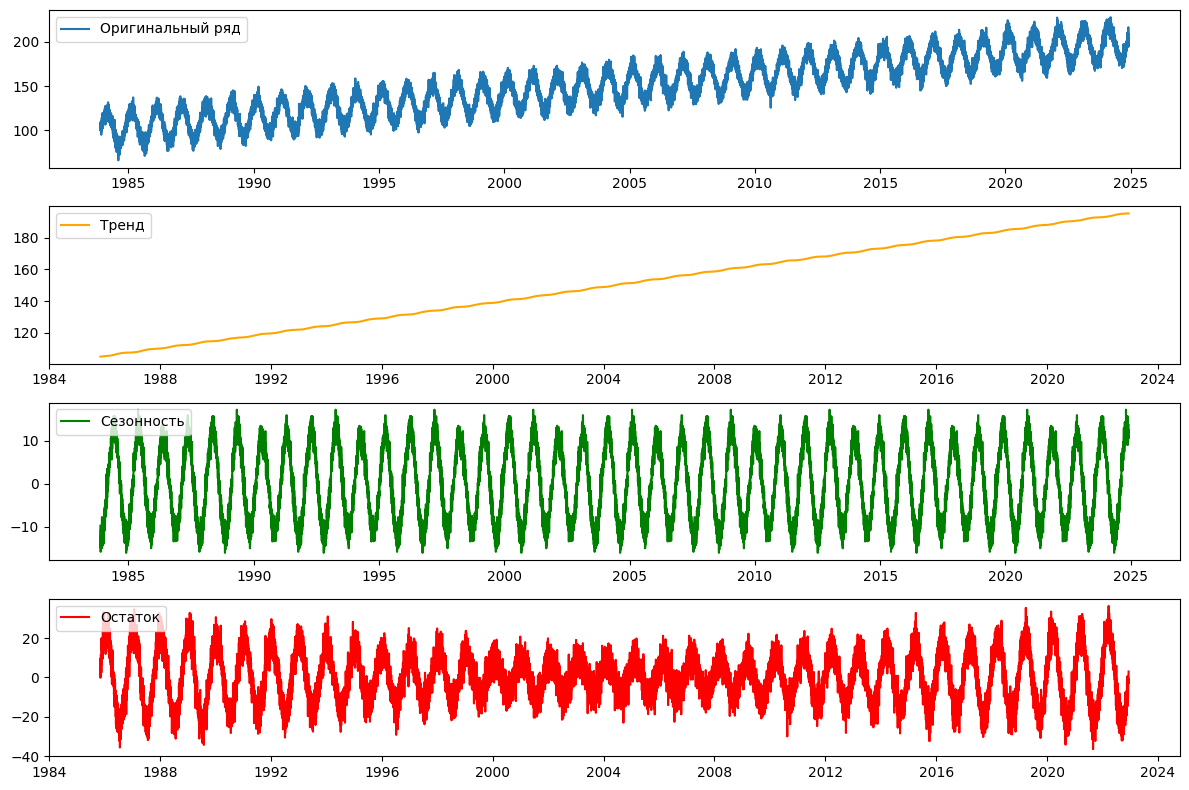

In [17]:
train = ts[:-12]  # Все данные, кроме последних 12 периодов
test = ts[-12:]   # Последние 12 периодов для проверки
#Декомпозиция временного ряда
decomposition = seasonal_decompose(train, model='additive', period=1440)
trend = decomposition.trend
seasonal = decomposition.seasonal

# Визуализация компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(train, label='Оригинальный ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Тренд', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Сезонность', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остаток', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

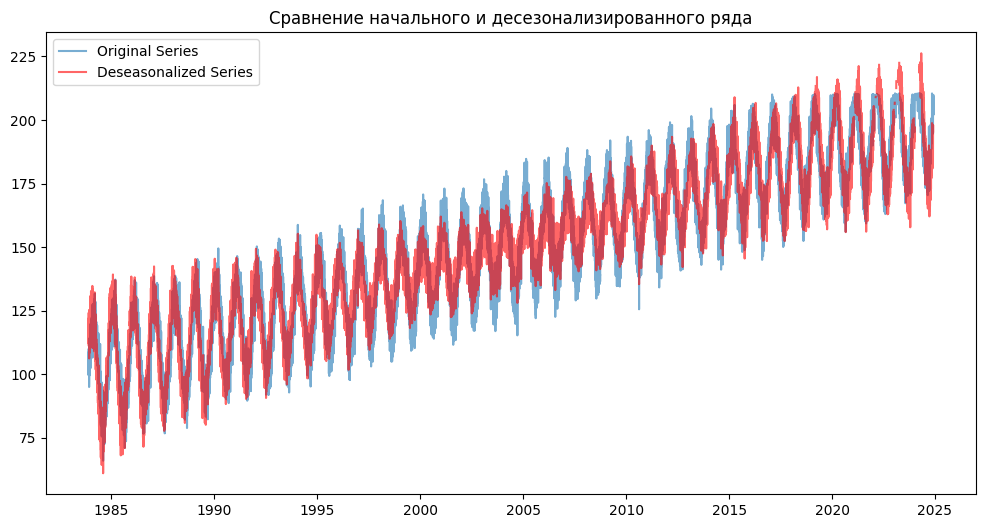

In [19]:
ts = ts[ts < ts.quantile(0.99)]  # Удаление значений выше 99-го перцентиля
deseasonalized = ts - decomposition.seasonal



plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original Series', alpha=0.6)
plt.plot(deseasonalized, label='Deseasonalized Series', alpha=0.6, color='red')
plt.title('Сравнение начального и десезонализированного ряда')
plt.legend(loc='best')
plt.show()

MAE: 3.443
RMSE: 4.137


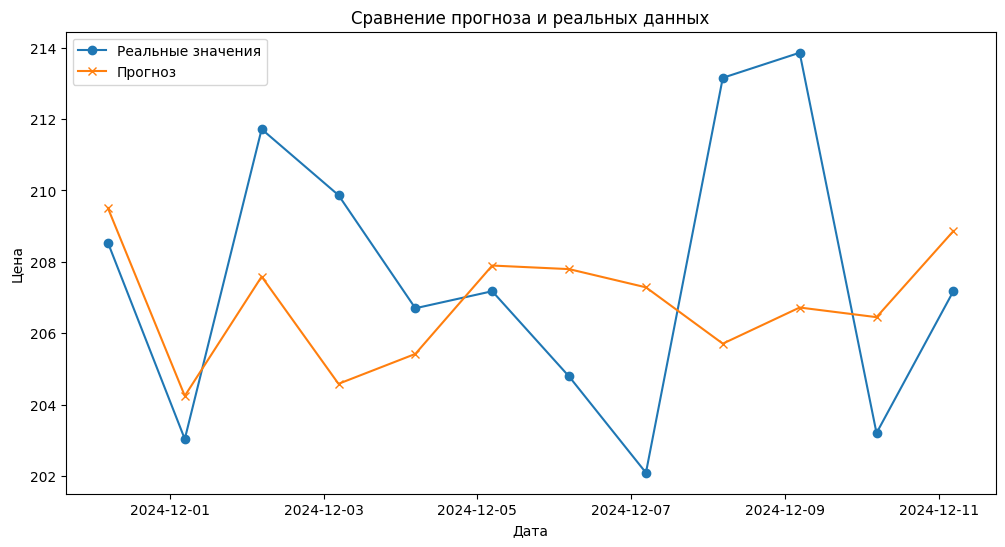

In [20]:
# Прогноз на основе тренда и сезонности
# Убедимся, что длины тренда и сезонности корректны для последних 12 периодов
last_trend = trend.dropna().iloc[-12:]  # Берем последние 12 значений тренда
last_seasonal = seasonal[-12:]          # Берем последние 12 значений сезонности

# Длины совпадают(должны)
assert len(last_trend) == len(test), "Длина тренда и тестовой выборки не совпадает"
assert len(last_seasonal) == len(test), "Длина сезонности и тестовой выборки не совпадает"

# Прогноз значений: сумма последнего тренда и сезонности
forecast = last_trend.values + last_seasonal.values

# Оценка качества прогноза
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Реальные значения', marker='o')
plt.plot(test.index, forecast, label='Прогноз', marker='x')
plt.title('Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# Шаг 2: Тест на стационарность (тест Дики-Фуллера)
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

print("Тест на стационарность для исходного ряда:")
adf_test(ts)

# Приведение ряда к стационарному виду, если необходимо
ts_diff = ts.diff().dropna()

print("\nТест на стационарность для дифференцированного ряда:")
adf_test(ts_diff)

# Шаг 3: Построение моделей AR, MA, ARMA и ARIMA
# Оптимизация параметров моделей с использованием AIC и BIC
def evaluate_model(X, model_type, p_values, q_values, d=0):
    best_aic, best_bic, best_order, best_model = float('inf'), float('inf'), None, None
    print(f"\nТестирование модели {model_type}...")
    for p in p_values:
        for q in q_values:
            try:
                print(f"Тестируем параметры: p={p}, d={d}, q={q}")
                if model_type == 'AR':
                    model = ARIMA(X, order=(p, 0, 0))
                elif model_type == 'MA':
                    model = ARIMA(X, order=(0, 0, q))
                elif model_type == 'ARMA':
                    model = ARIMA(X, order=(p, 0, q))
                elif model_type == 'ARIMA':
                    model = ARIMA(X, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                bic = fitted_model.bic
                print(f"Результат: AIC={aic:.3f}, BIC={bic:.3f}")
                if aic < best_aic:
                    best_aic, best_bic, best_order, best_model = aic, bic, (p, d, q), fitted_model
            except Exception as e:
                print(f"Ошибка для параметров p={p}, d={d}, q={q}: {e}")
                continue
    print(f"Лучшие параметры для {model_type}: order={best_order}, AIC={best_aic:.3f}, BIC={best_bic:.3f}")
    return best_aic, best_bic, best_order, best_model

# Диапазон значений для p и q
p_values = range(0, 4)
q_values = range(0, 4)

# AR
ar_aic, ar_bic, ar_order, ar_model = evaluate_model(ts_diff, 'AR', p_values, [0])
print(f"Лучший AR: order={ar_order}, AIC={ar_aic}, BIC={ar_bic}")

Тест на стационарность для исходного ряда:
ADF Statistic: -6.67635625672546
p-value: 4.454987356838589e-09
Critical Values:
	1%: -3.430796203134561
	5%: -2.8617372021448264
	10%: -2.5668749660005434
Ряд стационарен.

Тест на стационарность для дифференцированного ряда:
ADF Statistic: -8.333427226750864
p-value: 3.3210866372901825e-13
Critical Values:
	1%: -3.4307962335829005
	5%: -2.861737215600641
	10%: -2.5668749731629283
Ряд стационарен.

Тестирование модели AR...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=99160.146, BIC=99175.337
Тестируем параметры: p=1, d=0, q=0
Результат: AIC=94965.295, BIC=94988.082
Тестируем параметры: p=2, d=0, q=0
Результат: AIC=93254.296, BIC=93284.679
Тестируем параметры: p=3, d=0, q=0
Результат: AIC=92362.768, BIC=92400.746
Лучшие параметры для AR: order=(3, 0, 0), AIC=92362.768, BIC=92400.746
Лучший AR: order=(3, 0, 0), AIC=92362.76842387833, BIC=92400.74643774216


In [22]:
# MA
ma_aic, ma_bic, ma_order, ma_model = evaluate_model(ts_diff, 'MA', [0], q_values)
print(f"Лучший MA: order={ma_order}, AIC={ma_aic}, BIC={ma_bic}")


Тестирование модели MA...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=99160.146, BIC=99175.337
Тестируем параметры: p=0, d=0, q=1
Результат: AIC=91188.871, BIC=91211.658
Тестируем параметры: p=0, d=0, q=2
Результат: AIC=91146.462, BIC=91176.845
Тестируем параметры: p=0, d=0, q=3
Результат: AIC=91102.890, BIC=91140.868
Лучшие параметры для MA: order=(0, 0, 3), AIC=91102.890, BIC=91140.868
Лучший MA: order=(0, 0, 3), AIC=91102.89026599049, BIC=91140.86827985432


In [23]:
# ARMA
arma_aic, arma_bic, arma_order, arma_model = evaluate_model(ts_diff, 'ARMA', p_values, q_values)
print(f"Лучший ARMA: order={arma_order}, AIC={arma_aic}, BIC={arma_bic}")

# ARIMA
arima_aic, arima_bic, arima_order, arima_model = evaluate_model(ts, 'ARIMA', p_values, q_values, d=1)
print(f"Лучший ARIMA: order={arima_order}, AIC={arima_aic}, BIC={arima_bic}")


Тестирование модели ARMA...
Тестируем параметры: p=0, d=0, q=0
Результат: AIC=99160.146, BIC=99175.337
Тестируем параметры: p=0, d=0, q=1
Результат: AIC=91188.871, BIC=91211.658
Тестируем параметры: p=0, d=0, q=2
Результат: AIC=91146.462, BIC=91176.845
Тестируем параметры: p=0, d=0, q=3
Результат: AIC=91102.890, BIC=91140.868
Тестируем параметры: p=1, d=0, q=0
Результат: AIC=94965.295, BIC=94988.082
Тестируем параметры: p=1, d=0, q=1
Результат: AIC=91151.667, BIC=91182.049
Тестируем параметры: p=1, d=0, q=2
Результат: AIC=90185.960, BIC=90223.938
Тестируем параметры: p=1, d=0, q=3
Результат: AIC=90185.358, BIC=90230.931
Тестируем параметры: p=2, d=0, q=0
Результат: AIC=93254.296, BIC=93284.679
Тестируем параметры: p=2, d=0, q=1
Результат: AIC=91118.115, BIC=91156.093
Тестируем параметры: p=2, d=0, q=2
Результат: AIC=90205.574, BIC=90251.147
Тестируем параметры: p=2, d=0, q=3
Результат: AIC=90189.957, BIC=90243.126
Тестируем параметры: p=3, d=0, q=0
Результат: AIC=92362.768, BIC=92400.

In [24]:
# Шаг 4: Прогнозирование на 30 дней вперед
forecast_horizon = 30

# Прогноз ARIMA
arima_forecast = arima_model.forecast(steps=forecast_horizon)

# Прогноз ARMA
arma_forecast = arma_model.forecast(steps=forecast_horizon)

# Прогноз AR
ar_forecast = ar_model.forecast(steps=forecast_horizon)

# Прогноз MA
ma_forecast = ma_model.forecast(steps=forecast_horizon)

# Шаг 5: Оценка качества прогнозов (MAE, RMSE, MAPE)
def evaluate_forecast(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    return mae, rmse, mape

# Для сравнения: возьмем последние 30 значений истинного ряда
true_values = ts[-forecast_horizon:]

# Оценка моделей
ar_metrics = evaluate_forecast(true_values, ar_forecast)
ma_metrics = evaluate_forecast(true_values, ma_forecast)
arma_metrics = evaluate_forecast(true_values, arma_forecast)
arima_metrics = evaluate_forecast(true_values, arima_forecast)

print(f"AR Metrics: MAE={ar_metrics[0]:.3f}, RMSE={ar_metrics[1]:.3f}, MAPE={ar_metrics[2]:.3f}")
print(f"MA Metrics: MAE={ma_metrics[0]:.3f}, RMSE={ma_metrics[1]:.3f}, MAPE={ma_metrics[2]:.3f}")
print(f"ARMA Metrics: MAE={arma_metrics[0]:.3f}, RMSE={arma_metrics[1]:.3f}, MAPE={arma_metrics[2]:.3f}")
print(f"ARIMA Metrics: MAE={arima_metrics[0]:.3f}, RMSE={arima_metrics[1]:.3f}, MAPE={arima_metrics[2]:.3f}")

AR Metrics: MAE=202.278, RMSE=202.336, MAPE=1.000
MA Metrics: MAE=202.265, RMSE=202.324, MAPE=1.000
ARMA Metrics: MAE=201.990, RMSE=202.049, MAPE=0.999
ARIMA Metrics: MAE=8.160, RMSE=9.103, MAPE=0.041


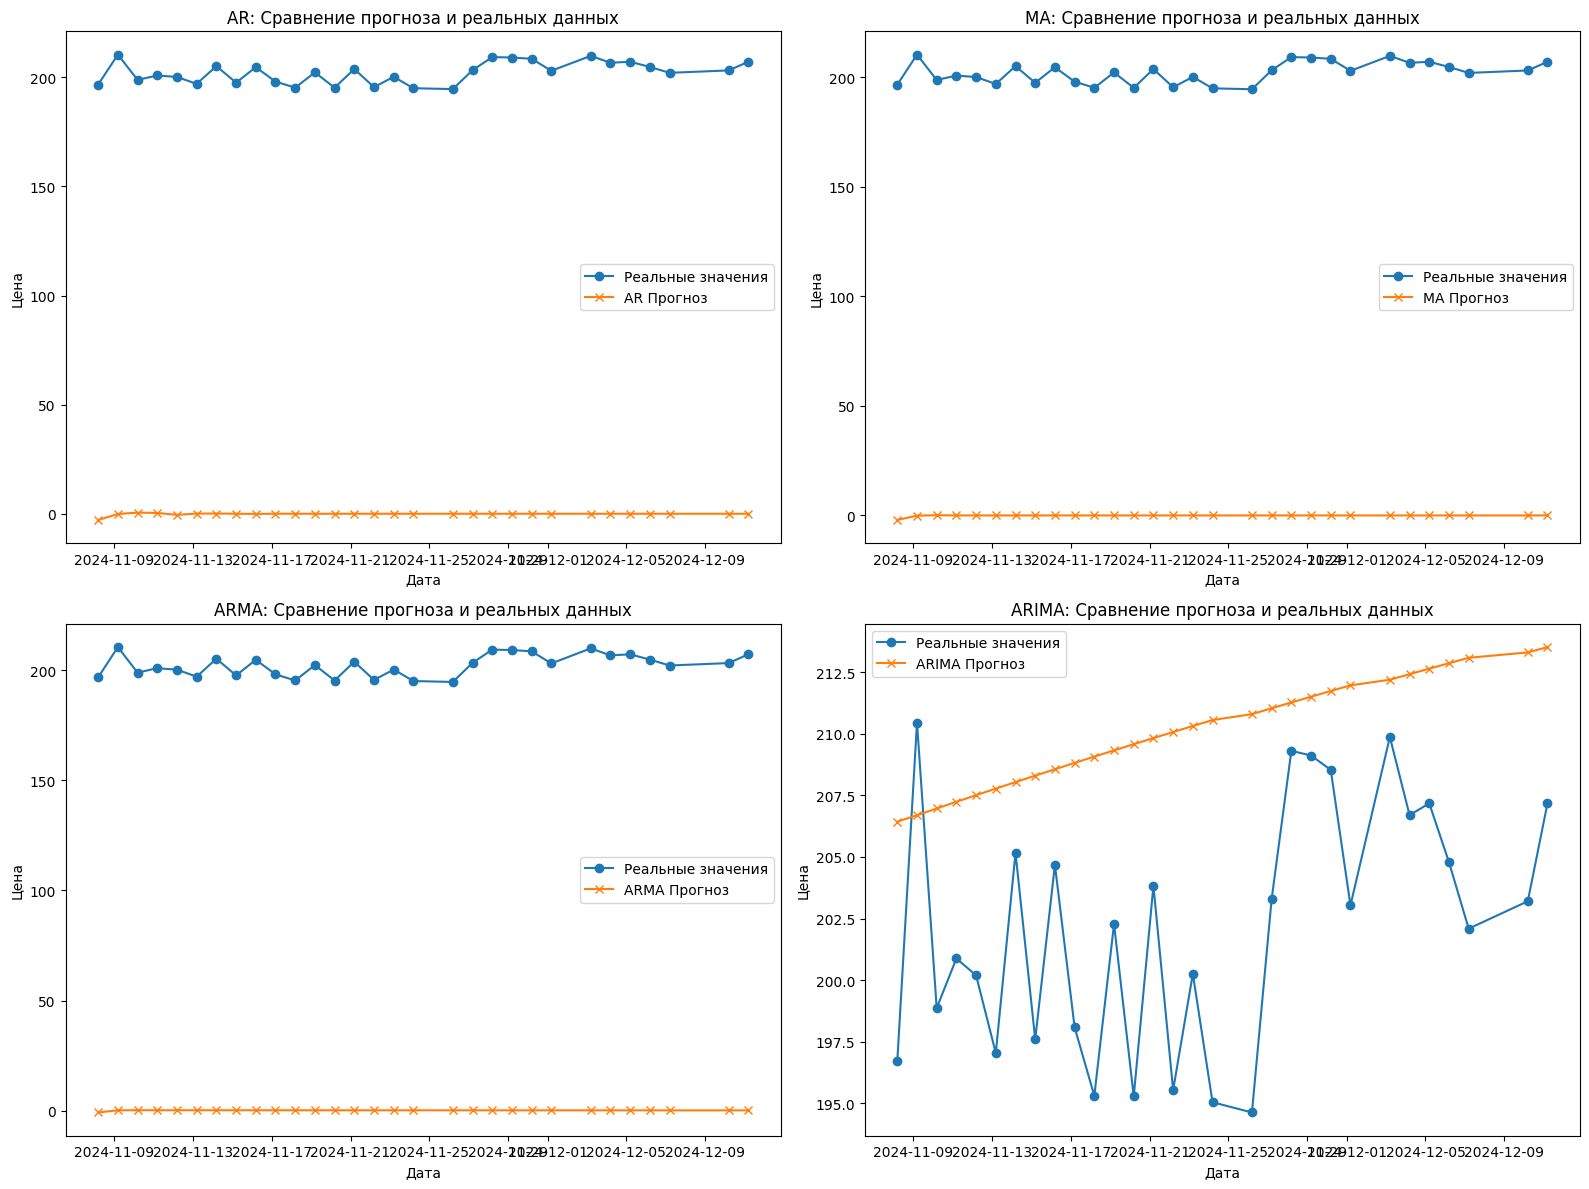

In [25]:
# Шаг 6: Визуализация результатов прогнозирования
plt.figure(figsize=(16, 12))

# AR
plt.subplot(2, 2, 1)
plt.plot(true_values.index, true_values, label='Реальные значения', marker='o')
plt.plot(true_values.index, ar_forecast, label='AR Прогноз', marker='x')
plt.title('AR: Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# MA
plt.subplot(2, 2, 2)
plt.plot(true_values.index, true_values, label='Реальные значения', marker='o')
plt.plot(true_values.index, ma_forecast, label='MA Прогноз', marker='x')
plt.title('MA: Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# ARMA
plt.subplot(2, 2, 3)
plt.plot(true_values.index, true_values, label='Реальные значения', marker='o')
plt.plot(true_values.index, arma_forecast, label='ARMA Прогноз', marker='x')
plt.title('ARMA: Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# ARIMA
plt.subplot(2, 2, 4)
plt.plot(true_values.index, true_values, label='Реальные значения', marker='o')
plt.plot(true_values.index, arima_forecast, label='ARIMA Прогноз', marker='x')
plt.title('ARIMA: Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()

# Настройка и отображение графиков
plt.tight_layout()
plt.show()